# 08_train_with_robust_aug.ipynb

This notebook trains **robust** presence and segmentation models using lighter, phone-realistic augmentations.

Per epoch, it evaluates:
- **Clean validation**
- **Degraded JPEG (S2)** and **Low-Resolution (S2)** slices — *if* the manifest exists at
`processed/degraded_sets/degraded_manifest.parquet` (created by `07_make_degraded_sets.ipynb`).

Outputs are saved under `runs/`:
- `presence_mobilenetv2_robust.pt`
- `unet_resnet34_aquavplant_robust.pt`
- `presence_threshold_robust.json` (best F1 threshold on clean val)


In [ ]:
!pip install 'segmentation_models_pytorch'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:00


In [ ]:

# --- Environment & paths (Colab-ready) ---
from google.colab import drive
print("Mounting Google Drive...")
try:
    drive.mount('/content/drive/', force_remount=True)
except Exception as e:
    print(f"Error mounting drive: {e}")

from pathlib import Path
import os, json, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import f1_score, accuracy_score, jaccard_score
from tqdm.auto import tqdm
import segmentation_models_pytorch as smp
import timm


# --- Paths aligned to current pipeline ---
ROOT = Path("/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data")
CSV_PATH = ROOT / "processed/metadata.csv"
DEGRAD_MANIFEST = ROOT / "processed/degraded_sets" / "degraded_manifest.parquet"
RUNS_DIR = ROOT / "runs"
RUNS_DIR.mkdir(parents=True, exist_ok=True)

# Output weights
PRES_W_ROBUST = RUNS_DIR / "presence_mobilenetv2_robust.pt"
SEG_W_ROBUST  = RUNS_DIR / "unet_resnet34_aquavplant_robust.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Reproducibility
def set_seed(s=1337):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(1337)
g = torch.Generator(); g.manual_seed(1337)


Mounting Google Drive...
Mounted at /content/drive/
Using device: cuda


In [ ]:
# === Viz helpers ===
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, auc

def _to_numpy_img(t):
    # tensor [C,H,W] -> [H,W,C] uint8
    if hasattr(t, "detach"):
        t = t.detach().cpu().numpy()
    if t.ndim == 3 and t.shape[0] in (1,3):
        t = t.transpose(1,2,0)
    t = (t * 255.0) if t.max()<=1.0 else t
    return t.astype("uint8")

def show_grid(images, titles=None, cols=4, figsize=(12,8)):
    rows = (len(images)+cols-1)//cols
    plt.figure(figsize=figsize)
    for i,im in enumerate(images):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(im)
        ax.axis("off")
        if titles and i < len(titles):
            ax.set_title(titles[i], fontsize=10)
    plt.tight_layout(); plt.show()

def overlay_pred_gt(rgb, pred_bin, gt_bin):
    # rgb: [H,W,3] uint8; pred_bin/gt_bin: [H,W] {0,1}
    ov = rgb.copy()
    ov[pred_bin==1, 0] = 255   # red channel for pred
    ov[gt_bin==1, 1] = 255     # green channel for GT
    return ov

def plot_curves(history, title="Training Curves"):
    plt.figure(figsize=(10,6))
    for k,v in history.items():
        if isinstance(v, (list, tuple)) and len(v)>0:
            plt.plot(range(1, len(v)+1), v, label=k)
    plt.xlabel("Epoch"); plt.title(title); plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()

def plot_bar(names, values, title):
    plt.figure(figsize=(7,5))
    plt.bar(names, values)
    plt.title(title)
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

def plot_confusion_and_roc(y_true, y_prob, thr, title_prefix="Presence (Val)"):
    # Confusion
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.8,4.8))
    plt.imshow(cm, cmap='Blues'); plt.title(f"{title_prefix} — Confusion @ thr={thr:.2f}")
    plt.xticks([0,1], ["No Hyacinth","Hyacinth"]); plt.yticks([0,1], ["No Hyacinth","Hyacinth"])
    for (i,j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha='center', va='center', fontsize=12)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar(); plt.tight_layout(); plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5.6,5.0))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} — ROC"); plt.legend()
    plt.grid(True, alpha=0.3); plt.show()


In [ ]:

# --- Load metadata (train/eval splits) & degraded manifest (optional) ---
df = pd.read_csv(CSV_PATH)

# Presence training set (Bangladesh)
train_cls_df = df.query("source=='bangladesh_augmented' and split=='train'").reset_index(drop=True)
val_cls_df   = df.query("source=='bangladesh_augmented' and split=='val'").reset_index(drop=True)

# Segmentation training set (AqUavplant)
train_seg_df = df.query("source=='aquavplant' and split=='train'").reset_index(drop=True)
val_seg_df   = df.query("source=='aquavplant' and split=='val'").reset_index(drop=True)

print(f"Presence: {len(train_cls_df)} train / {len(val_cls_df)} val")
print(f"Segmentation: {len(train_seg_df)} train / {len(val_seg_df)} val")

# Optional degraded eval slices for segmentation
has_degraded = DEGRAD_MANIFEST.exists()
if has_degraded:
    df_deg = pd.read_parquet(DEGRAD_MANIFEST)
    df_deg_val = df_deg.query("split=='val'").copy().reset_index(drop=True)
    # Make sure severity is int for filtering
    if df_deg_val["severity"].dtype != np.int64 and df_deg_val["severity"].dtype != np.int32:
        df_deg_val["severity"] = df_deg_val["severity"].astype(int)
    print("Degraded val manifest found:", len(df_deg_val), "rows")
    print("Corruptions:", sorted(df_deg_val['corruption'].unique().tolist()))
    print("Severities:", sorted(df_deg_val['severity'].unique().tolist()))
else:
    df_deg_val = None
    print("No degraded manifest found; degraded eval will be skipped.")


Presence: 2603 train / 643 val
Segmentation: 148 train / 27 val
Degraded val manifest found: 405 rows
Corruptions: ['brightness', 'defocus', 'jpeg', 'lowres', 'noise']
Severities: [1, 2, 3]


In [ ]:

# --- Augmentations ---
SIZE_CLS = 224
tfm_train_cls_robust = A.Compose([
    A.LongestMaxSize(max_size=SIZE_CLS),
    A.PadIfNeeded(min_height=SIZE_CLS, min_width=SIZE_CLS, border_mode=0, value=(128,128,128)),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, border_mode=0, value=(128,128,128), p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(1, 3), p=0.3),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),
    A.ImageCompression(quality_lower=50, quality_upper=100, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
tfm_eval_cls = A.Compose([
    A.LongestMaxSize(max_size=SIZE_CLS),
    A.PadIfNeeded(min_height=SIZE_CLS, min_width=SIZE_CLS, border_mode=0, value=(128,128,128)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

SIZE_SEG = 512
tfm_train_seg_robust = A.Compose([
    A.LongestMaxSize(max_size=SIZE_SEG),
    A.PadIfNeeded(min_height=SIZE_SEG, min_width=SIZE_SEG, border_mode=0, value=(128,128,128), mask_value=0),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, border_mode=0, value=(128,128,128), p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(1, 3), p=0.3),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),
    A.ImageCompression(quality_lower=50, quality_upper=100, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
tfm_eval_seg = A.Compose([
    A.LongestMaxSize(max_size=SIZE_SEG),
    A.PadIfNeeded(min_height=SIZE_SEG, min_width=SIZE_SEG, border_mode=0, value=(128,128,128), mask_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


/tmp/ipython-input-2966559213.py:5: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=SIZE_CLS, min_width=SIZE_CLS, border_mode=0, value=(128,128,128)),
/tmp/ipython-input-2966559213.py:7: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=10, border_mode=0, value=(128,128,128), p=0.3),
/tmp/ipython-input-2966559213.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),
/tmp/ipython-input-2966559213.py:11: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=50, quality_upper=100, p=0.5),
/tmp/ipython-input-2966559213.py:17: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=SIZE_CLS, min_width=SIZE_CLS, border_mode=0, value=(128,128,128)),
/tmp/ipython-input-2966559213.py:25: UserWarning: Argument(s)

In [ ]:
class PresenceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = np.array(Image.open(row.image_path).convert("RGB"))
        if self.transform:
            img = self.transform(image=img)["image"]
        label = torch.tensor(row.has_hyacinth, dtype=torch.float32)
        return img, label

class SegmentationDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img  = np.array(Image.open(row.image_path).convert("RGB"))
        mask = np.array(Image.open(row.mask_path).convert("L"))
        mask = (mask > 127).astype(np.float32)
        if self.transform:
            out = self.transform(image=img, mask=mask)
            img, mask = out["image"], out["mask"]
            # After ToTensorV2, mask is already a tensor. Ensure it has a channel dim.
            if mask.ndim == 2: # If ToTensorV2 returned (H,W)
                mask = mask.unsqueeze(0)
            return img, mask
        else:
            # If no transform, mask is a numpy array. Convert to tensor and add channel dim.
            return img, torch.from_numpy(mask).unsqueeze(0)

def make_loader(ds, bs, shuffle, generator=None):
    return DataLoader(ds, batch_size=bs, shuffle=shuffle, num_workers=0, pin_memory=False, persistent_workers=False, generator=generator)

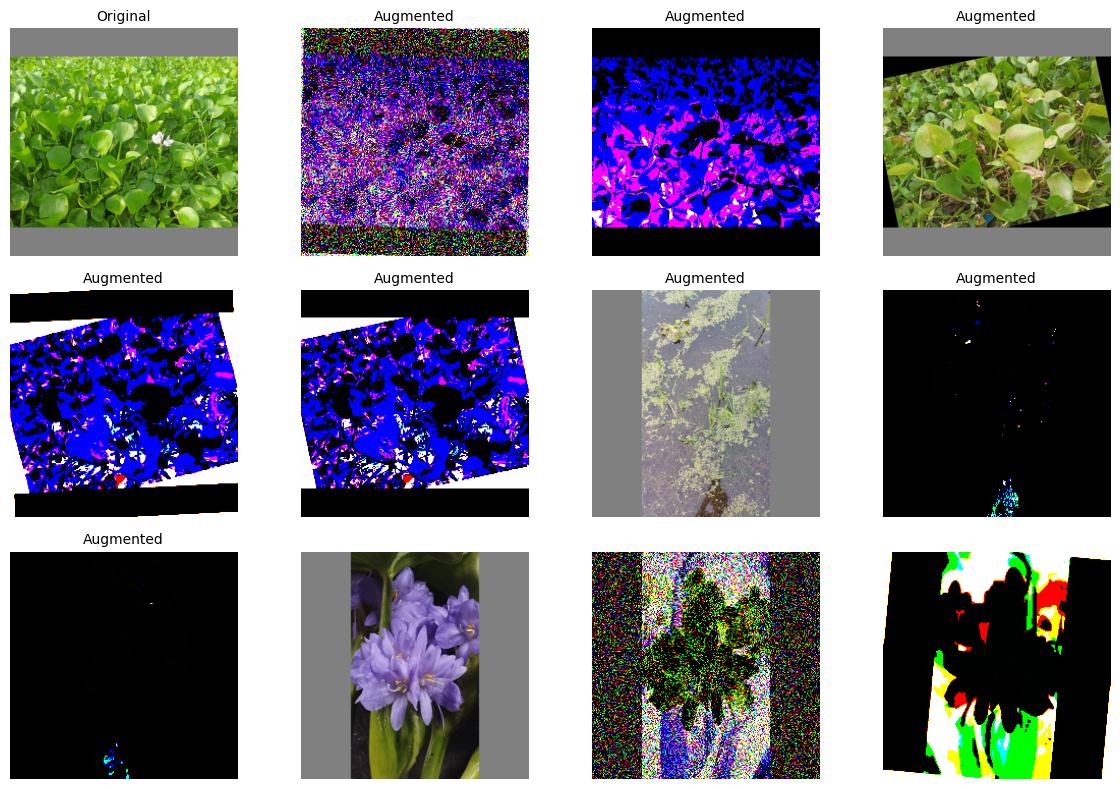

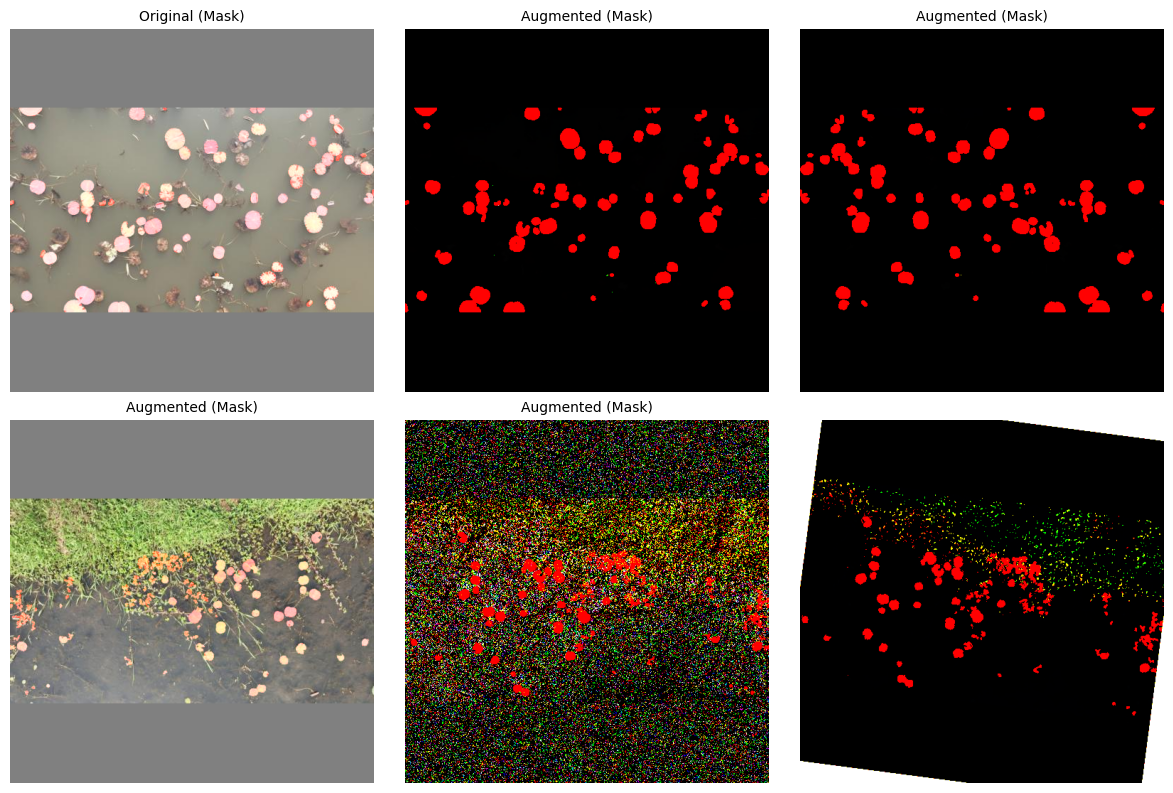

In [ ]:
# === Aug preview: Presence ===
sample_cls = train_cls_df.sample(4, random_state=7)
imgs = []
for _, r in sample_cls.iterrows():
    raw = np.array(Image.open(r.image_path).convert("RGB"))
    imgs.append(raw)
    # show a few augmented variants of same image
    for _ in range(2):
        aug = tfm_train_cls_robust(image=raw)["image"]
        imgs.append(_to_numpy_img(aug/255.0) if aug.max()>1 else _to_numpy_img(aug))

show_grid(imgs[:12], titles=["Original"] + ["Augmented"]*2*4)

# === Aug preview: Segmentation (overlay mask) ===
sample_seg = train_seg_df.sample(2, random_state=13)
imgs = []
for _, r in sample_seg.iterrows():
    raw = np.array(Image.open(r.image_path).convert("RGB"))
    msk = (np.array(Image.open(r.mask_path).convert("L"))>127).astype(np.uint8)
    # raw
    imgs.append(overlay_pred_gt(raw, msk, np.zeros_like(msk)))
    # a few augmented
    for _ in range(2):
        out = tfm_train_seg_robust(image=raw, mask=msk)
        aug_img = _to_numpy_img(out["image"]/255.0) if out["image"].max()>1 else _to_numpy_img(out["image"])
        aug_m  = out["mask"].to(torch.uint8).cpu().numpy()
        imgs.append(overlay_pred_gt(aug_img, aug_m, np.zeros_like(aug_m)))

show_grid(imgs, titles=["Original (Mask)"] + ["Augmented (Mask)"]*2*2, cols=3)

In [ ]:
# --- Models & Losses ---
# Presence (MobileNetV2)
presence_model = timm.create_model('mobilenetv2_100', pretrained=True, num_classes=1).to(device)

# Segmentation (UNet-ResNet34)
seg_model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1).to(device)

cls_loss_fn = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
bce_loss_fn = smp.losses.SoftBCEWithLogitsLoss()
def combined_seg_loss(pred, target):
    return 0.5 * dice_loss(pred, target) + 0.5 * bce_loss_fn(pred, target)


model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
# --- Evaluation helpers ---
@torch.no_grad()
def evaluate(model, loader, loss_fn, task_type='cls', threshold=0.5):
    model.eval()
    total_loss = 0.0
    preds_all, labels_all = [], []
    for x, y in loader:
        x = x.to(device); y = y.to(device)
        logits = model(x)
        y_loss = y.unsqueeze(1) if task_type=='cls' else y
        loss = loss_fn(logits, y_loss)
        total_loss += loss.item()
        p = torch.sigmoid(logits).detach().cpu().numpy()
        preds_all.append(p)
        labels_all.append(y.detach().cpu().numpy())
    avg_loss = total_loss / max(1, len(loader))
    preds_all = np.concatenate(preds_all, axis=0) if preds_all else np.zeros((0,1,))
    labels_all = np.concatenate(labels_all, axis=0) if labels_all else np.zeros((0,))

    if task_type=='cls':
        thresholds = np.linspace(0.05, 0.95, 19)
        bin_preds = [(preds_all > t).astype(int) for t in thresholds]
        f1s = [f1_score(labels_all, bp) for bp in bin_preds] if len(labels_all)>0 else [0.0]*len(thresholds)
        best_idx = int(np.argmax(f1s))
        best_f1, best_thresh = float(f1s[best_idx]), float(thresholds[best_idx])
        acc = accuracy_score(labels_all, bin_preds[best_idx]) if len(labels_all)>0 else 0.0
        return avg_loss, best_f1, acc, best_thresh
    else:
        preds_bin = (preds_all > threshold).astype(int)
        labels_bin = (labels_all > 0.5).astype(int)
        if preds_bin.size == 0:
            return avg_loss, 0.0, 0.0, 0.0
        iou = jaccard_score(labels_bin.flatten(), preds_bin.flatten(), average='binary')
        dice = f1_score(labels_bin.flatten(), preds_bin.flatten(), average='binary')
        cover_pred = preds_bin.reshape(preds_bin.shape[0], -1).mean(axis=1)
        cover_true = labels_bin.reshape(labels_bin.shape[0], -1).mean(axis=1)
        cover_abs_err = float(np.mean(np.abs(cover_pred - cover_true)))
        return avg_loss, float(iou), float(dice), cover_abs_err


In [ ]:
import torch.cuda.amp
# --- Training helper (AMP + grad clipping) ---
# Using torch.amp.GradScaler
scaler = torch.amp.GradScaler(enabled=(device=='cuda'))

def train_one_epoch(model, loader, optimizer, loss_fn, task_type='cls', max_norm=1.0):
    model.train()
    total = 0.0
    # Add tqdm for batch-level progress
    for x, y in tqdm(loader, desc="Training Batches"):
        x = x.to(device); y = y.to(device)
        optimizer.zero_grad(set_to_none=True)
        # Using torch.amp.autocast with device_type explicitly set
        with torch.amp.autocast(device_type='cuda', enabled=(device=='cuda')):
            logits = model(x)
            y_loss = y.unsqueeze(1) if task_type=='cls' else y
            loss = loss_fn(logits, y_loss)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        scaler.step(optimizer); scaler.update()
        total += loss.item()
    return total / max(1, len(loader))

In [ ]:
# --- Build degraded eval loaders for segmentation (S2 slices) ---
def make_seg_loader_from_df(df_like, bs=16):
    ds = SegmentationDataset(df_like, transform=tfm_eval_seg)
    return make_loader(ds, bs=bs, shuffle=False, generator=g)

jpeg_loader_seg = None
lowres_loader_seg = None
if df_deg_val is not None:
    jpeg_s2 = df_deg_val.query("corruption == 'jpeg' and severity == 2").reset_index(drop=True)
    lowres_s2 = df_deg_val.query("corruption == 'lowres' and severity == 2").reset_index(drop=True)
    jpeg_loader_seg   = make_seg_loader_from_df(jpeg_s2)   if len(jpeg_s2)   > 0 else None
    lowres_loader_seg = make_seg_loader_from_df(lowres_s2) if len(lowres_s2) > 0 else None
    print("Degraded eval slices -> jpeg S2:", len(jpeg_s2), "| lowres S2:", len(lowres_s2))


Degraded eval slices -> jpeg S2: 27 | lowres S2: 27


In [ ]:
# === History buffers for plots ===
hist = {
    "cls_train_loss": [], "cls_val_loss": [], "cls_f1": [], "cls_acc": [],
    "seg_train_loss": [], "seg_val_loss": [], "seg_iou": [], "seg_dice": [], "seg_coverErr": [],
    "seg_jpegS2_iou": [], "seg_lowresS2_iou": []
}

Training Batches:   0%|          | 0/82 [00:00<?, ?it/s]

[Presence][1/10] Train 1.0573 | Val 0.4395 | F1 0.8984 | Acc 0.9518 | Thr* 0.80
  -> Saved best presence model & threshold


Training Batches:   0%|          | 0/82 [00:00<?, ?it/s]

[Presence][2/10] Train 0.4556 | Val 0.2029 | F1 0.9651 | Acc 0.9829 | Thr* 0.75
  -> Saved best presence model & threshold


Training Batches:   0%|          | 0/82 [00:00<?, ?it/s]

[Presence][3/10] Train 0.3307 | Val 0.0684 | F1 0.9679 | Acc 0.9844 | Thr* 0.85
  -> Saved best presence model & threshold


Training Batches:   0%|          | 0/82 [00:00<?, ?it/s]

[Presence][4/10] Train 0.2456 | Val 0.0313 | F1 0.9811 | Acc 0.9907 | Thr* 0.60
  -> Saved best presence model & threshold


Training Batches:   0%|          | 0/82 [00:00<?, ?it/s]

[Presence][5/10] Train 0.1851 | Val 0.0253 | F1 0.9875 | Acc 0.9938 | Thr* 0.85
  -> Saved best presence model & threshold


Training Batches:   0%|          | 0/82 [00:00<?, ?it/s]

[Presence][6/10] Train 0.1966 | Val 0.0228 | F1 0.9874 | Acc 0.9938 | Thr* 0.15


Training Batches:   0%|          | 0/82 [00:00<?, ?it/s]

[Presence][7/10] Train 0.1415 | Val 0.0126 | F1 0.9937 | Acc 0.9969 | Thr* 0.30
  -> Saved best presence model & threshold


Training Batches:   0%|          | 0/82 [00:00<?, ?it/s]

[Presence][8/10] Train 0.1434 | Val 0.0209 | F1 0.9905 | Acc 0.9953 | Thr* 0.30


Training Batches:   0%|          | 0/82 [00:00<?, ?it/s]

[Presence][9/10] Train 0.1067 | Val 0.0047 | F1 0.9968 | Acc 0.9984 | Thr* 0.45
  -> Saved best presence model & threshold


Training Batches:   0%|          | 0/82 [00:00<?, ?it/s]

[Presence][10/10] Train 0.1096 | Val 0.0143 | F1 0.9968 | Acc 0.9984 | Thr* 0.05
Presence done. Best F1: 0.9968454258675079 Best Thr: 0.44999999999999996


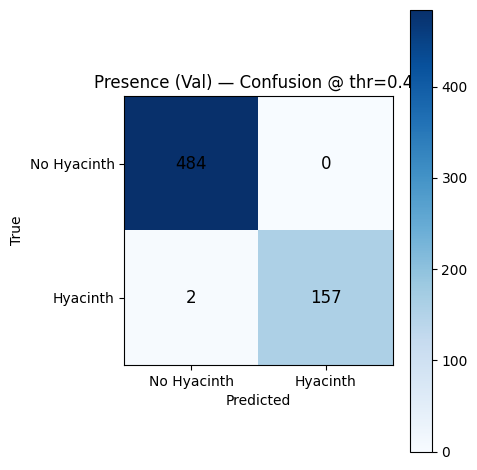

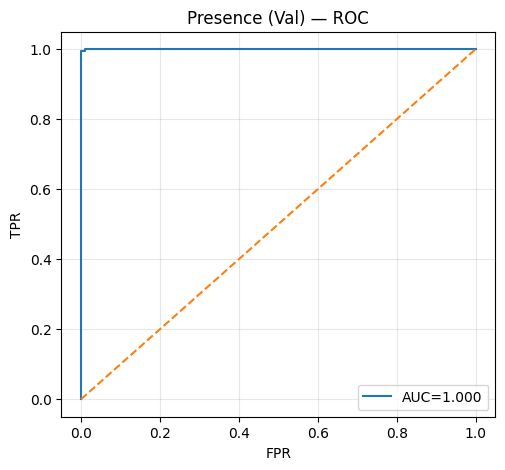

In [ ]:
# --- Train Presence (robust augs) ---
N_EPOCHS_CLS = 10
LR_CLS = 1e-4

dl_train_cls = make_loader(PresenceDataset(train_cls_df, tfm_train_cls_robust), 32, True, g)
dl_val_cls   = make_loader(PresenceDataset(val_cls_df,   tfm_eval_cls),       64, False, g)

presence_opt = optim.Adam(presence_model.parameters(), lr=LR_CLS)
best_f1_cls, best_thresh_cls = -1.0, 0.5

for epoch in range(1, N_EPOCHS_CLS+1):
    tr = train_one_epoch(presence_model, dl_train_cls, presence_opt, cls_loss_fn, task_type='cls')
    vl, vf1, vacc, vthr = evaluate(presence_model, dl_val_cls, cls_loss_fn, task_type='cls')
    print(f"[Presence][{epoch}/{N_EPOCHS_CLS}] Train {tr:.4f} | Val {vl:.4f} | F1 {vf1:.4f} | Acc {vacc:.4f} | Thr* {vthr:.2f}")
    hist["cls_train_loss"].append(tr); hist["cls_val_loss"].append(vl)
    hist["cls_f1"].append(vf1); hist["cls_acc"].append(vacc)
    if vf1 > best_f1_cls:
        best_f1_cls, best_thresh_cls = vf1, vthr
        torch.save(presence_model.state_dict(), PRES_W_ROBUST)
        with open(RUNS_DIR / "presence_threshold_robust.json", "w") as f:
            json.dump({"best_threshold": float(best_thresh_cls)}, f)
        print("  -> Saved best presence model & threshold")

print("Presence done. Best F1:", best_f1_cls, "Best Thr:", best_thresh_cls)

# Confusion + ROC on clean val
presence_model.eval()
all_prob, all_lab = [], []
with torch.no_grad():
    for xb, yb in dl_val_cls:
        xb = xb.to(device)
        p = torch.sigmoid(presence_model(xb)).cpu().numpy().reshape(-1)
        all_prob.append(p); all_lab.append(yb.numpy())
all_prob = np.concatenate(all_prob); all_lab = np.concatenate(all_lab)
thr = 0.5
pth = RUNS_DIR / "presence_threshold_robust.json"
if pth.exists():
    thr = json.load(open(pth))["best_threshold"]
plot_confusion_and_roc(all_lab.astype(int), all_prob, thr, title_prefix="Presence (Val)")


In [ ]:
# --- Train Segmentation (robust augs) with freeze->unfreeze & degraded eval ---
N_EPOCHS_SEG = 15
LR_SEG = 1e-4

for p in seg_model.encoder.parameters(): p.requires_grad = False

dl_train_seg = make_loader(SegmentationDataset(train_seg_df, tfm_train_seg_robust), 8, True, g)
dl_val_seg   = make_loader(SegmentationDataset(val_seg_df,   tfm_eval_seg),       16, False, g)

seg_opt = optim.Adam(seg_model.parameters(), lr=LR_SEG)
best_iou_seg = -1.0

for epoch in range(1, N_EPOCHS_SEG+1):
    if epoch == 4:
        for p in seg_model.encoder.parameters(): p.requires_grad = True
        seg_opt = optim.Adam(seg_model.parameters(), lr=LR_SEG)

    tr = train_one_epoch(seg_model, dl_train_seg, seg_opt, combined_seg_loss, task_type='seg')
    vl, viou, vdice, vcover = evaluate(seg_model, dl_val_seg, combined_seg_loss, task_type='seg')
    print(f"[Seg][{epoch}/{N_EPOCHS_SEG}] Train {tr:.4f} | Val {vl:.4f} | IoU {viou:.4f} | Dice {vdice:.4f} | CoverErr {vcover:.4f}")
    hist["seg_train_loss"].append(tr); hist["seg_val_loss"].append(vl)
    hist["seg_iou"].append(viou); hist["seg_dice"].append(vdice); hist["seg_coverErr"].append(vcover)

    if 'jpeg_loader_seg' in globals() and jpeg_loader_seg is not None:
        _, jiou, jdice, jcover = evaluate(seg_model, jpeg_loader_seg, combined_seg_loss, task_type='seg')
        print(f"   ↳ Val(jpeg S2): IoU {jiou:.4f} | Dice {jdice:.4f} | CoverErr {jcover:.4f}")
        hist["seg_jpegS2_iou"].append(jiou)
    if 'lowres_loader_seg' in globals() and lowres_loader_seg is not None:
        _, liou, ldice, lcover = evaluate(seg_model, lowres_loader_seg, combined_seg_loss, task_type='seg')
        print(f"   ↳ Val(lowres S2): IoU {liou:.4f} | Dice {ldice:.4f} | CoverErr {lcover:.4f}")
        hist["seg_lowresS2_iou"].append(liou)

    if viou > best_iou_seg:
        best_iou_seg = viou
        torch.save(seg_model.state_dict(), SEG_W_ROBUST)
        print("  -> Saved best segmentation model (clean IoU)")

print("Segmentation done. Best clean IoU:", best_iou_seg)
print("Saved models to:", PRES_W_ROBUST, "and", SEG_W_ROBUST)


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][1/15] Train 0.7227 | Val 0.6754 | IoU 0.2347 | Dice 0.3801 | CoverErr 0.3017
   ↳ Val(jpeg S2): IoU 0.2332 | Dice 0.3783 | CoverErr 0.3050
   ↳ Val(lowres S2): IoU 0.2339 | Dice 0.3791 | CoverErr 0.3050
  -> Saved best segmentation model (clean IoU)


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][2/15] Train 0.6277 | Val 0.6121 | IoU 0.3036 | Dice 0.4658 | CoverErr 0.2546
   ↳ Val(jpeg S2): IoU 0.3018 | Dice 0.4636 | CoverErr 0.2542
   ↳ Val(lowres S2): IoU 0.3024 | Dice 0.4644 | CoverErr 0.2468
  -> Saved best segmentation model (clean IoU)


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][3/15] Train 0.5741 | Val 0.5218 | IoU 0.3819 | Dice 0.5528 | CoverErr 0.1754
   ↳ Val(jpeg S2): IoU 0.3826 | Dice 0.5535 | CoverErr 0.1718
   ↳ Val(lowres S2): IoU 0.3753 | Dice 0.5458 | CoverErr 0.1599
  -> Saved best segmentation model (clean IoU)


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][4/15] Train 0.5183 | Val 0.4761 | IoU 0.4613 | Dice 0.6314 | CoverErr 0.1029
   ↳ Val(jpeg S2): IoU 0.4625 | Dice 0.6324 | CoverErr 0.1000
   ↳ Val(lowres S2): IoU 0.4807 | Dice 0.6493 | CoverErr 0.0599
  -> Saved best segmentation model (clean IoU)


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][5/15] Train 0.4774 | Val 0.4426 | IoU 0.5104 | Dice 0.6759 | CoverErr 0.0794
   ↳ Val(jpeg S2): IoU 0.5107 | Dice 0.6761 | CoverErr 0.0785
   ↳ Val(lowres S2): IoU 0.5267 | Dice 0.6900 | CoverErr 0.0601
  -> Saved best segmentation model (clean IoU)


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][6/15] Train 0.4598 | Val 0.4031 | IoU 0.5786 | Dice 0.7331 | CoverErr 0.0408
   ↳ Val(jpeg S2): IoU 0.5772 | Dice 0.7320 | CoverErr 0.0403
   ↳ Val(lowres S2): IoU 0.5563 | Dice 0.7149 | CoverErr 0.0264
  -> Saved best segmentation model (clean IoU)


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][7/15] Train 0.4220 | Val 0.4336 | IoU 0.4880 | Dice 0.6559 | CoverErr 0.1081
   ↳ Val(jpeg S2): IoU 0.4752 | Dice 0.6442 | CoverErr 0.1146
   ↳ Val(lowres S2): IoU 0.5130 | Dice 0.6781 | CoverErr 0.0791


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][8/15] Train 0.3972 | Val 0.3573 | IoU 0.6092 | Dice 0.7571 | CoverErr 0.0401
   ↳ Val(jpeg S2): IoU 0.6051 | Dice 0.7540 | CoverErr 0.0379
   ↳ Val(lowres S2): IoU 0.4536 | Dice 0.6241 | CoverErr 0.0478
  -> Saved best segmentation model (clean IoU)


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][9/15] Train 0.3828 | Val 0.3458 | IoU 0.6091 | Dice 0.7571 | CoverErr 0.0390
   ↳ Val(jpeg S2): IoU 0.6082 | Dice 0.7564 | CoverErr 0.0370
   ↳ Val(lowres S2): IoU 0.5778 | Dice 0.7324 | CoverErr 0.0310


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][10/15] Train 0.3861 | Val 0.3305 | IoU 0.6208 | Dice 0.7661 | CoverErr 0.0301
   ↳ Val(jpeg S2): IoU 0.6122 | Dice 0.7594 | CoverErr 0.0300
   ↳ Val(lowres S2): IoU 0.5446 | Dice 0.7052 | CoverErr 0.0361
  -> Saved best segmentation model (clean IoU)


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][11/15] Train 0.3566 | Val 0.3227 | IoU 0.6184 | Dice 0.7642 | CoverErr 0.0304
   ↳ Val(jpeg S2): IoU 0.6199 | Dice 0.7654 | CoverErr 0.0294
   ↳ Val(lowres S2): IoU 0.5813 | Dice 0.7352 | CoverErr 0.0289


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][12/15] Train 0.3470 | Val 0.3247 | IoU 0.6122 | Dice 0.7594 | CoverErr 0.0456
   ↳ Val(jpeg S2): IoU 0.6060 | Dice 0.7547 | CoverErr 0.0469
   ↳ Val(lowres S2): IoU 0.6018 | Dice 0.7514 | CoverErr 0.0269


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][13/15] Train 0.3333 | Val 0.3171 | IoU 0.6007 | Dice 0.7506 | CoverErr 0.0537
   ↳ Val(jpeg S2): IoU 0.5825 | Dice 0.7362 | CoverErr 0.0588
   ↳ Val(lowres S2): IoU 0.5862 | Dice 0.7391 | CoverErr 0.0415


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][14/15] Train 0.3212 | Val 0.2909 | IoU 0.6350 | Dice 0.7768 | CoverErr 0.0325
   ↳ Val(jpeg S2): IoU 0.6328 | Dice 0.7751 | CoverErr 0.0329
   ↳ Val(lowres S2): IoU 0.6131 | Dice 0.7601 | CoverErr 0.0258
  -> Saved best segmentation model (clean IoU)


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[Seg][15/15] Train 0.3133 | Val 0.2692 | IoU 0.6621 | Dice 0.7967 | CoverErr 0.0218
   ↳ Val(jpeg S2): IoU 0.6574 | Dice 0.7933 | CoverErr 0.0204
   ↳ Val(lowres S2): IoU 0.5316 | Dice 0.6941 | CoverErr 0.0434
  -> Saved best segmentation model (clean IoU)
Segmentation done. Best clean IoU: 0.6620711919252712
Saved models to: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/presence_mobilenetv2_robust.pt and /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/unet_resnet34_aquavplant_robust.pt


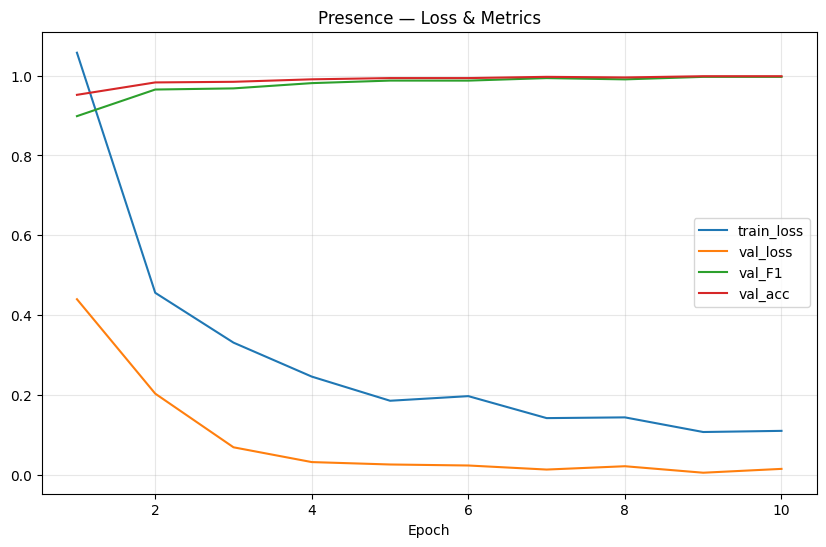

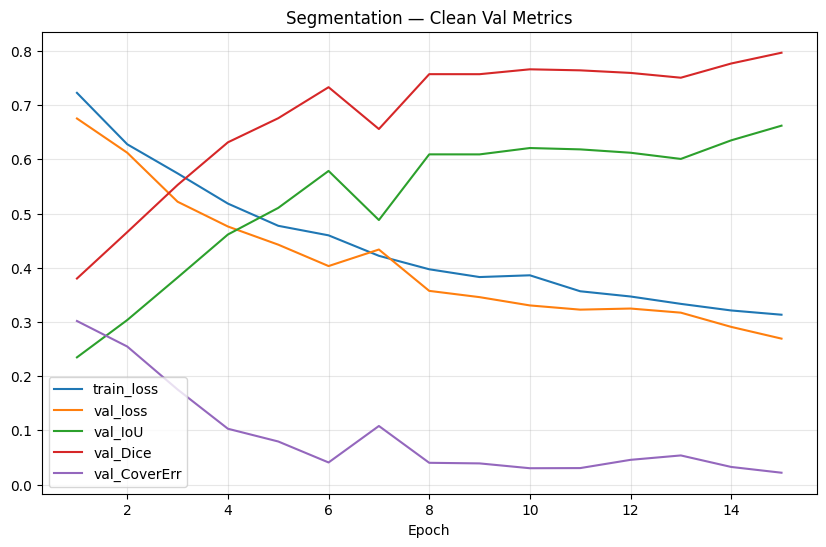

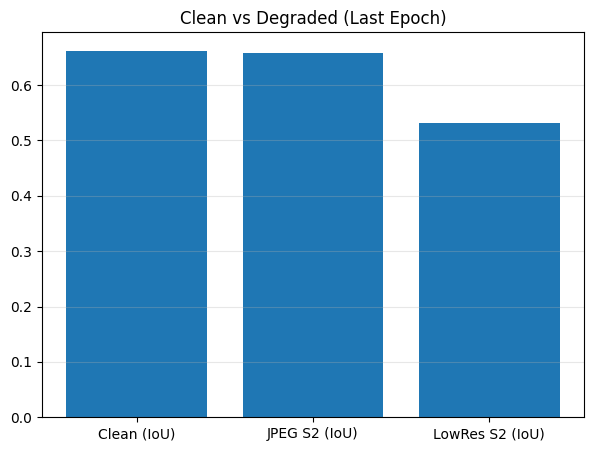

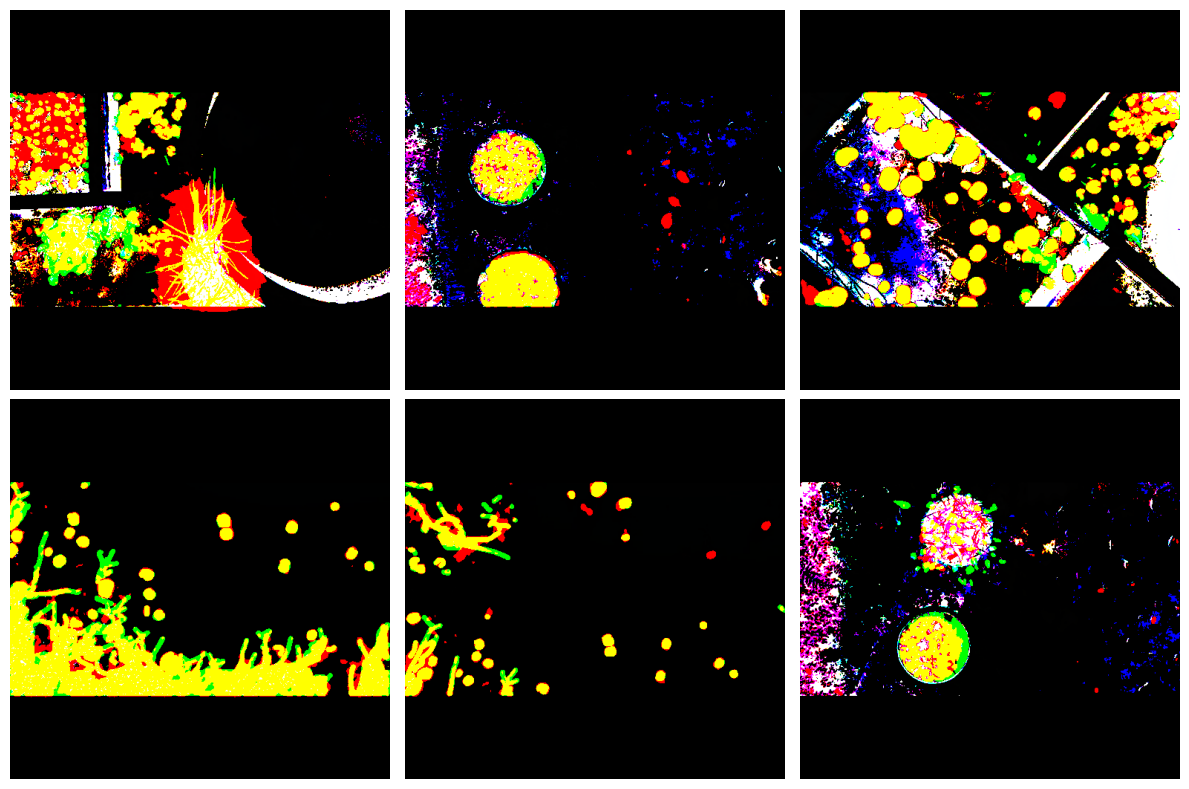

In [ ]:
# === Plot curves & qualitative overlays ===
plot_curves({
    "train_loss": hist["cls_train_loss"],
    "val_loss":   hist["cls_val_loss"],
    "val_F1":     hist["cls_f1"],
    "val_acc":    hist["cls_acc"],
}, title="Presence — Loss & Metrics")

plot_curves({
    "train_loss": hist["seg_train_loss"],
    "val_loss":   hist["seg_val_loss"],
    "val_IoU":    hist["seg_iou"],
    "val_Dice":   hist["seg_dice"],
    "val_CoverErr": hist["seg_coverErr"],
}, title="Segmentation — Clean Val Metrics")

names, vals = [], []
if len(hist["seg_iou"])>0:
    names.append("Clean (IoU)"); vals.append(hist["seg_iou"][-1])
if len(hist["seg_jpegS2_iou"])>0:
    names.append("JPEG S2 (IoU)"); vals.append(hist["seg_jpegS2_iou"][-1])
if len(hist["seg_lowresS2_iou"])>0:
    names.append("LowRes S2 (IoU)"); vals.append(hist["seg_lowresS2_iou"][-1])
if len(names)>0:
    plot_bar(names, vals, "Clean vs Degraded (Last Epoch)")

# Qualitative overlays
seg_model.eval()
subset = val_seg_df.sample(min(6, len(val_seg_df)), random_state=42)
tiles = []
with torch.no_grad():
    for _, r in subset.iterrows():
        rgb = np.array(Image.open(r.image_path).convert("RGB"))
        msk = (np.array(Image.open(r.mask_path).convert("L"))>127).astype(np.uint8)
        out = tfm_eval_seg(image=rgb, mask=msk)
        x  = out["image"].unsqueeze(0).to(device)
        pred = torch.sigmoid(seg_model(x))[0,0].cpu().numpy()
        pred_bin = (pred > 0.5).astype(np.uint8)
        tiles.append(overlay_pred_gt(_to_numpy_img(out["image"]/255.0), pred_bin, msk))
show_grid(tiles, cols=3)